In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import re
#import tweepy #need pip installing
# from tweepy.streaming import StreamListener
# from tweepy import OAuthHandler
# from tweepy import Stream

In [3]:
df = pd.read_csv('tweets.csv')

In [4]:
pd.options.display.max_colwidth = 10000

In [5]:
d = Counter(" ".join(df.text.str.lower()).split(" "))
d_s = sorted(d, key=d.get, reverse=True)

In [6]:
emoticons_str = r"""
    (?:
        [:=;] # Eyes
        [oO\-]? # Nose (optional)
        [D\)\]\(\]/\\OpP] # Mouth
    )"""

regex_str = [
    emoticons_str,
    r'<[^>]+>',  # HTML tags
    r'(?:@[\w_]+)',  # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)",  # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&amp;+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+',  # URLs

    r'(?:(?:\d+,?)+(?:\.?\d+)?)',  # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])",  # words with - and '
    r'(?:[\w_]+)',  # other words
    r'(?:\S)'  # anything else
]
tokens_re = re.compile(r'(' + '|'.join(regex_str) + ')', re.VERBOSE | re.IGNORECASE)
def tokenize(s):
    return tokens_re.findall(s)


def preprocess_tweet(s, lowercase=False):
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

def contains_punc(l):
    if '.' in l or ',' in l or '?' in l:
        return True
    else: return False

def count_punc(l):
    c = 0
    for a in l:
        if '.' in a or ',' in a or '?' in a:
            c+=1
    return c

In [7]:
# df['MatchDuration'] = pd.to_datetime(df['MatchDuration'])
# df['MatchDuration'] = df['MatchDuration'].dt.second + df['MatchDuration'].dt.minute*60
# df = df.sort_values(by = 'MatchDuration')
# df['MatchDuration'] = pd.cut(df['MatchDuration'] ,bins = list(range(0,61,5)), labels = list(range(5,61,5)), include_lowest=True)
df['hour'] = pd.to_datetime(df['created_at']).dt.hour
df['time_of_day'] = 0 
df['time_of_day'][((df['hour'] > 7) & (df['hour'] <12)) | (df['hour'] == 7)] = 1
df['time_of_day'][((df['hour'] > 12) & (df['hour'] <17)) | (df['hour'] == 12)] = 2
df['time_of_day'][((df['hour'] > 17) & (df['hour'] <23))  | (df['hour'] == 17)] = 3

C:\Users\avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
df['punc'] = df['text'].apply(preprocess_tweet).apply(contains_punc)
df['punc_num'] = df['text'].apply(preprocess_tweet).apply(count_punc)
df['popularity'] = (0.1 * df["favorite_count"] + 0.9 * df["retweet_count"]) / (1+ np.log(df["user.followers_count"]))
df['count_link'] = df['text'].str.count('http')
df['contain_link'] = 0
df['contain_link'][df['count_link'] > 0] = 1
df['len_text'] = df['text'].str.len()

C:\Users\avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: divide by zero encountered in log
  app.launch_new_instance()
C:\Users\avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [9]:
df['popularity'] = (0.1 * df["favorite_count"] + 0.9 * df["retweet_count"])/(1+ np.log(df["user.followers_count"]))
df['popularity'] = df['popularity'].replace([np.inf, -np.inf], np.nan)

C:\Users\avi\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


In [10]:
c_l = pd.DataFrame(df.groupby('count_link')['popularity'].mean())
c_p = pd.DataFrame(df.groupby('punc_num')['popularity'].mean())
h_l = pd.DataFrame(df.groupby('contain_link')['popularity'].mean())
h_p = pd.DataFrame(df.groupby('punc')['popularity'].mean())

In [11]:
c_p['num'] = pd.cut(c_p.index.get_values() ,bins = [0,1,2,3,4,5,6,100], labels = list(range(0,7)), include_lowest=True)
c_p = pd.DataFrame(c_p.groupby('num')['popularity'].mean())

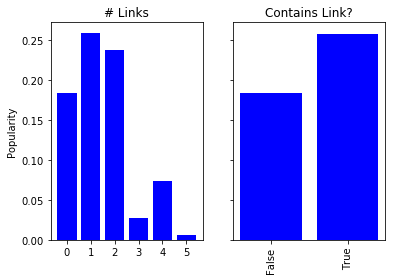

In [55]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(c_l.index.get_values(), c_l['popularity']\
        , align='center', color = 'b')
ax1.set_xticks(c_l.index.get_values())
ax1.set_title('# Links')
ax1.set_ylabel('Popularity')
ax2.bar(h_l.index.get_values(), h_l['popularity']\
        , align='center', color = 'b')
ax2.set_xticks(h_l.index.get_values())
ax2.set_xticklabels(['False', 'True'], rotation='vertical') 
ax2.set_title('Contains Link?')
plt.savefig('pop_link.jpg', bbox_inches = 'tight')
plt.show()

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.bar(c_p.index.get_values(), c_p['popularity']\
        , align='center', color = 'b')
ax1.set_xticks(c_p.index.get_values())
ax1.set_xticklabels(list(range(0,6))+['>5'])
ax1.set_title('# Punc.')
ax1.set_ylabel('Popularity')
ax2.bar(h_p.index.get_values(), h_p['popularity']\
        , align='center', color = 'b')
ax2.set_xticks(h_p.index.get_values())
ax2.set_xticklabels(['False', 'True'], rotation='vertical') 
ax2.set_title('Contains Punc?')
plt.savefig('pop_punc.jpg', bbox_inches = 'tight')
plt.show()

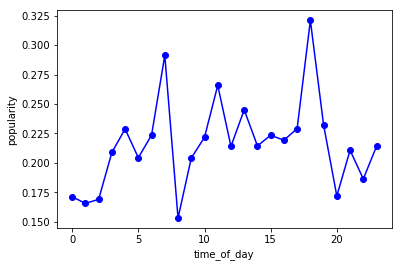

In [15]:
h = pd.DataFrame(df.groupby('hour')['popularity'].mean())
x = h.index.get_values()
y = h['popularity']
plt.plot(x, y, 'bo-')
plt.xlabel('time_of_day')
plt.ylabel('popularity')
plt.savefig('pop_hour.jpg', bbox_inches = 'tight')
plt.show()

In [51]:
ln = pd.DataFrame(df.groupby('len_text')['popularity'].mean())
pd.qcut(ln.index.get_values(), 10, labels = list(range(1,11)))
# list(range(0,11))

[1, 1, 1, 1, 1, ..., 10, 10, 10, 10, 10]
Length: 159
Categories (10, int64): [1 < 2 < 3 < 4 ... 7 < 8 < 9 < 10]

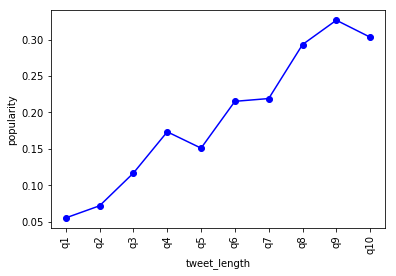

In [53]:
#list1 = list(range(0,170,10))
#list2 = list(range(10,171,10))
#labels = [str(x)+'-'+str(y) for x,y in zip(list1, list2)]
labels = ['q'+str(y) for y in list(range(1,11))]

ln = pd.DataFrame(df.groupby('len_text')['popularity'].mean())
ln['num'] = pd.qcut(ln.index.get_values(), 10, labels = list(range(1,11)))
ln = pd.DataFrame(ln.groupby('num')['popularity'].mean())
x = ln.index.get_values()
y = ln['popularity']
plt.plot(x, y, 'bo-')
plt.xlabel('tweet_length')
plt.ylabel('popularity')
plt.xticks(x, labels, rotation='vertical')
plt.savefig('pop_len.jpg', bbox_inches = 'tight')
plt.show()

In [113]:
pd.set_option('float_format', '{:f}'.format)
pd.options.display.max_colwidth = 1000

In [269]:
print(df['text'][169961])
print(df['text'][89373])

End of the world proceeding on schedule 
#Election2016 https://t.co/l0KIB2NKK4
Congress full of reps again with a republican president 🙄 they might actually agree


In [270]:
df['text'][df['text'].str.contains('republicans')]

254                        If neither candidate hits 270 EV, congress decides- republicans hold majority in house + senate so trump victory guaranteed
288       To drop bombs, invade other nations etc you need the approval of congress and republicans has control of congress a… https://t.co/y2RkDHKJWX
525                                                                            "Them republicans wouldn't let him!!!"...hahaha https://t.co/7hjMfWJiUT
724                         @Kantuva And the congress is chock full of republicans who want to push no gay marriage rescind tons of social programming
2229         The republicans held congress, and did a good job sitting on their ass passing nothing. But we will remember and they will face the music
2363                                                                   I'm at peace with whoever is president. As long as republicans control congress
2748      @DanHawkTweets your republican friends in congress can and I'm sure Trump will be th

In [11]:
df.groupby(['contain_link', 'time_of_day']).count()

text  created_at   geo    lang  place  \
contain_link time_of_day                                            
0            0             62303       62303    44   62303   4847   
             1             39538       39538    46   39538   3084   
             2             72883       72883    53   72883   6814   
             3             12885       12885    10   12885    824   
1            0             47871       47871   193   47871   3080   
             1             37159       37159   290   37159   2310   
             2            108498      108498  1775  108498   8965   
             3             16492       16492   153   16492    908   

                          coordinates  user.favourites_count  \
contain_link time_of_day                                       
0            0                     44                  62303   
             1                     46                  39538   
             2                     53                  72883   
             3                     10                  12885   
1            0                    193                  47871   
             1                    290                  37159   
             2                   1775                 108498   
             3                    153                  16492   

                          user.statuses_count  user.description  \
contain_link time_of_day                                          
0            0                          62303             55413   
             1                          39538             34971   
             2                          72883             65298   
             3                          12885             10412   
1            0                          47871             42670   
             1                          37159             32846   
             2                         108498             97614   
             3                          16492             14185   

                          user.location    ...         id  favorite_count  \
contain_link time_of_day                   ...                              
0            0                    45726    ...      62303           62303   
             1                    29735    ...      39538           39538   
             2                    55902    ...      72883           72883   
             3                     8982    ...      12885           12885   
1            0                    36072    ...      47871           47871   
             1                    28179    ...      37159           37159   
             2                    85865    ...     108498          108498   
             3                    12229    ...      16492           16492   

                          retweeted  source  favorited  retweet_count    hour  \
contain_link time_of_day                                                        
0            0                62303   62303      62303          62303   62303   
             1                39538   39538      39538          39538   39538   
             2                72883   72883      72883          72883   72883   
             3                12885   12885      12885          12885   12885   
1            0                47871   47871      47871          47871   47871   
             1                37159   37159      37159          37159   37159   
             2               108498  108498     108498         108498  108498   
             3                16492   16492      16492          16492   16492   

                            punc  popularity  len_text  
contain_link time_of_day                                
0            0             62303       62160     62303  
             1             39538       39398     39538  
             2             72883       72747     72883  
             3             12885       12823     12885  
1            0             47871       47684     47871  
             1             37159       36977

In [12]:
df.groupby(['punc', 'time_of_day']).count()

text  created_at   geo   lang  place  coordinates  \
punc  time_of_day                                                       
False 0            40498       40498   144  40498   2913          144   
      1            30562       30562   203  30562   2033          203   
      2            82543       82543   827  82543   6778          827   
      3            11383       11383    82  11383    698           82   
True  0            69676       69676    93  69676   5014           93   
      1            46135       46135   133  46135   3361          133   
      2            98838       98838  1001  98838   9001         1001   
      3            17994       17994    81  17994   1034           81   

                   user.favourites_count  user.statuses_count  \
punc  time_of_day                                               
False 0                            40498                40498   
      1                            30562                30562   
      2                            82543                82543   
      3                            11383                11383   
True  0                            69676                69676   
      1                            46135                46135   
      2                            98838                98838   
      3                            17994                17994   

                   user.description  user.location    ...        id  \
punc  time_of_day                                     ...             
False 0                       35667          29388    ...     40498   
      1                       26535          22527    ...     30562   
      2                       73110          63445    ...     82543   
      3                        9402           8013    ...     11383   
True  0                       62416          52410    ...     69676   
      1                       41282          35387    ...     46135   
      2                       89802          78322    ...     98838   
      3                       15195          13198    ...     17994   

                   favorite_count  retweeted  source  favorited  \
punc  time_of_day                                                 
False 0                     40498      40498   40498      40498   
      1                     30562      30562   30562      30562   
      2                     82543      82543   82543      82543   
      3                     11383      11383   11383      11383   
True  0                     69676      69676   69676      69676   
      1                     46135      46135   46135      46135   
      2                     98838      98838   98838      98838   
      3                     17994      17994   17994      17994   

                   retweet_count   hour  popularity  contain_link  len_text  
punc  time_of_day                                                            
False 0                    40498  40498       40313         40498     40498  
      1                    30562  30562       30395         30562     30562  
      2                    82543  82543       82225         82543     82543  
      3                    11383  11383       11309         11383     11383  
True  0                    69676  69676       69531         69676     69676  
      1                    46135  46135       45980         46135     46135  
      2                    98838  98838       98515         98838     98838  
      3                    17994  17994       17933         17994     17994  

[8 rows x 38 columns]

In [14]:
pd.cut(df['len_text'] ,bins = list(range(0,250,10)), labels = list(range(0,240,10)), include_lowest=True)

0         130
1         130
2         100
3         130
4         110
5          70
6         130
7          90
8          50
9          90
10        100
11         80
12        130
13        120
14        130
15         60
16        130
17        130
18        130
19        140
20        110
21        130
22        130
23        130
24        130
25        110
26         90
27         60
28        130
29        130
         ... 
397599    130
397600    130
397601    130
397602     80
397603    130
397604     50
397605     70
397606     70
397607     80
397608    120
397609    110
397610     70
397611    110
397612    120
397613    130
397614     60
397615    120
397616     50
397617    130
397618     80
397619     80
397620    130
397621     50
397622     40
397623    120
397624     30
397625    120
397626    140
397627    130
397628     90
Name: len_text, Length: 397629, dtype: category
Categories (24, int64): [0 < 10 < 20 < 30 ... 200 < 210 < 220 < 230]

In [15]:
max(df['len_text'])

242

In [85]:
df[['contain_link', 'favorite_count']].corr()

,contain_link,favorite_count
contain_link,1.000000,0.005219
favorite_count,0.005219,1.000000


In [60]:
df['len_text'].mean()

100.03570665117483

In [64]:
df[['len_text', 'favorite_count']].corr()

,len_text,favorite_count
len_text,1.000000,0.012683
favorite_count,0.012683,1.000000


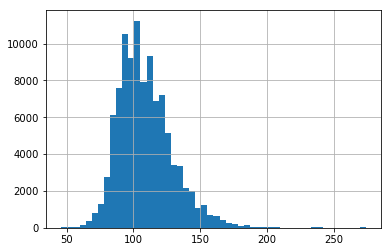

In [11]:
df['Glucose (mg/dL)'].hist(bins=50)
plt.show()

In [1]:
x = df[df.len_text < 200]['len_text']
y = df[df.len_text < 200]['favorite_count']
# fit = np.polyfit(x, y, deg=1)
# plt.plot(x, fit[0] * x + fit[1], color='red')
plt.scatter(x, y)
plt.xlabel('Length of tweet')
plt.ylabel('Number of Likes')
plt.show()

NameError: name 'df' is not defined

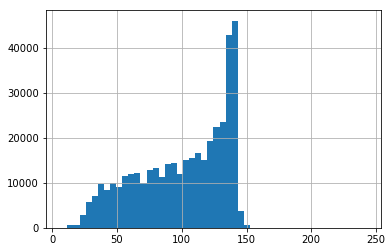

In [59]:
df['len_text'].hist(bins=50)
plt.show()

In [9]:
df.dtypes

text                              object
created_at                        object
geo                               object
lang                              object
place                             object
coordinates                       object
user.favourites_count              int64
user.statuses_count                int64
user.description                  object
user.location                     object
user.id                            int64
user.created_at                   object
user.verified                       bool
user.following                      bool
user.url                          object
user.listed_count                  int64
user.followers_count               int64
user.default_profile_image          bool
user.utc_offset                  float64
user.friends_count                 int64
user.default_profile                bool
user.name                         object
user.lang                         object
user.screen_name                  object
user.geo_enabled

In [21]:
auth = tweepy.OAuthHandler('J19vA7JMPSpYfOlg9c7UsOAZW', 'LQediYBcDd16tNvWpHVM5kbJSZ0gnNF4njlOSv74yscFZiDlnl')
auth.set_access_token('953172981894860800-hQYPinYuX1VYLpA1jVGGgNOqfx9waDl', '0RMg92ljRwJc1Vr9s47Q4uYzXbaMsOpufy9g6bcQ98sEC')

api = tweepy.API(auth)
l = StreamListener()
stream = Stream(auth, l)
print(stream.filter(track='a'))

KeyboardInterrupt: 

In [6]:
df.describe()

,user.favourites_count,user.statuses_count,user.id,user.listed_count,user.followers_count,user.utc_offset,user.friends_count,id,favorite_count,retweet_count
count,3.976290e+05,3.976290e+05,3.976290e+05,397629.000000,3.976290e+05,273213.000000,3.976290e+05,3.976290e+05,397629.000000,397629.000000
mean,6.534404e+03,3.266195e+04,8.544938e+16,129.148291,1.312490e+04,-15171.950456,1.382280e+03,7.960463e+17,3.904245,2.061175
std,1.771841e+04,1.333083e+05,2.393798e+17,1507.850561,3.014971e+05,14941.248417,8.094139e+03,1.261132e+14,80.573836,45.402889
min,0.000000e+00,1.000000e+00,5.800000e+01,0.000000,0.000000e+00,-39600.000000,0.000000e+00,7.958384e+17,0.000000,0.000000
25%,1.910000e+02,1.691000e+03,1.076806e+08,3.000000,1.410000e+02,-25200.000000,1.720000e+02,7.959733e+17,0.000000,0.000000
50%,1.271000e+03,7.058000e+03,4.919247e+08,13.000000,4.370000e+02,-18000.000000,4.290000e+02,7.960062e+17,0.000000,0.000000
75%,5.523000e+03,2.434600e+04,2.760873e+09,51.000000,1.401000e+03,-14400.000000,1.036000e+03,7.961606e+17,1.000000,0.000000
max,1.241637e+06,6.670043e+06,7.963360e+17,229213.000000,6.448915e+07,46800.000000,1.213060e+06,7.963387e+17,21244.000000,9855.000000


## Boolean indexing (WHERE in SQL, or Selection with Predicates):

In [29]:
df[df.views > 1000000]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,2290,"Body language affects how others see us, but i...",1262,TEDGlobal 2012,1340668800,51,Amy Cuddy,Amy Cuddy: Your body language may shape who yo...,1,1349103608,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 3...","[{'id': 605, 'hero': 'https://pe.tedcdn.com/im...",Social psychologist,"['body language', 'brain', 'business', 'psycho...",Your body language may shape who you are,https://www.ted.com/talks/amy_cuddy_your_body_...,43155405
2,1930,Simon Sinek has a simple but powerful model fo...,1084,TEDxPuget Sound,1253145600,45,Simon Sinek,Simon Sinek: How great leaders inspire action,1,1272965460,"[{'id': 21, 'name': 'Unconvincing', 'count': 9...","[{'id': 814, 'hero': 'https://pe.tedcdn.com/im...",Leadership expert,"['TEDx', 'business', 'entrepreneur', 'leadersh...",How great leaders inspire action,https://www.ted.com/talks/simon_sinek_how_grea...,34309432
3,1927,Brené Brown studies human connection -- our ab...,1219,TEDxHouston,1275782400,52,Brené Brown,Brené Brown: The power of vulnerability,1,1293115500,"[{'id': 10, 'name': 'Inspiring', 'count': 2144...","[{'id': 1391, 'hero': 'https://pe.tedcdn.com/i...",Vulnerability researcher,"['TEDx', 'communication', 'culture', 'depressi...",The power of vulnerability,https://www.ted.com/talks/brene_brown_on_vulne...,31168150
4,354,"""Bonk"" author Mary Roach delves into obscure s...",1003,TED2009,1233878400,37,Mary Roach,Mary Roach: 10 things you didn't know about or...,1,1242781200,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 3...","[{'id': 16, 'hero': 'https://pe.tedcdn.com/ima...",Writer,"['books', 'culture', 'history', 'humor', 'scie...",10 things you didn't know about orgasm,https://www.ted.com/talks/mary_roach_10_things...,22270883
5,297,"Have you ever felt like you're talking, but no...",598,TEDGlobal 2013,1370822400,45,Julian Treasure,Julian Treasure: How to speak so that people w...,1,1403879897,"[{'id': 24, 'name': 'Persuasive', 'count': 267...","[{'id': 1200, 'hero': 'https://pe.tedcdn.com/i...",Sound consultant,"['culture', 'sound', 'speech']",How to speak so that people want to listen,https://www.ted.com/talks/julian_treasure_how_...,21594632
6,2877,Jill Bolte Taylor got a research opportunity f...,1099,TED2008,1204070400,49,Jill Bolte Taylor,Jill Bolte Taylor: My stroke of insight,1,1205284200,"[{'id': 22, 'name': 'Fascinating', 'count': 14...","[{'id': 184, 'hero': 'https://pe.tedcdn.com/im...",Neuroanatomist,"['biology', 'brain', 'consciousness', 'global ...",My stroke of insight,https://www.ted.com/talks/jill_bolte_taylor_s_...,21190883
7,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,Tony Robbins: Why we do what we do,1,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401
8,150,"Suspicious emails: unclaimed insurance bonds, ...",588,TEDGlobal>Geneva,1449532800,43,James Veitch,James Veitch: This is what happens when you re...,1,1452269020,"[{'id': 7, 'name': 'Funny', 'count': 7731}, {'...","[{'id': 2236, 'hero': 'https://pe.tedcdn.com/i...",Comedian and writer,"['comedy', 'communication', 'curiosity', 'humo...",This is what happens when you reply to spam email,https://www.ted.com/talks/james_veitch_this_is...,2047597

In [32]:
df[df > 0]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
1,2290,"Body language affects how others see us, but i...",1262,TEDGlobal 2012,1340668800,51,Amy Cuddy,Amy Cuddy: Your body language may shape who yo...,1,1349103608,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 3...","[{'id': 605, 'hero': 'https://pe.tedcdn.com/im...",Social psychologist,"['body language', 'brain', 'business', 'psycho...",Your body language may shape who you are,https://www.ted.com/talks/amy_cuddy_your_body_...,43155405
2,1930,Simon Sinek has a simple but powerful model fo...,1084,TEDxPuget Sound,1253145600,45,Simon Sinek,Simon Sinek: How great leaders inspire action,1,1272965460,"[{'id': 21, 'name': 'Unconvincing', 'count': 9...","[{'id': 814, 'hero': 'https://pe.tedcdn.com/im...",Leadership expert,"['TEDx', 'business', 'entrepreneur', 'leadersh...",How great leaders inspire action,https://www.ted.com/talks/simon_sinek_how_grea...,34309432
3,1927,Brené Brown studies human connection -- our ab...,1219,TEDxHouston,1275782400,52,Brené Brown,Brené Brown: The power of vulnerability,1,1293115500,"[{'id': 10, 'name': 'Inspiring', 'count': 2144...","[{'id': 1391, 'hero': 'https://pe.tedcdn.com/i...",Vulnerability researcher,"['TEDx', 'communication', 'culture', 'depressi...",The power of vulnerability,https://www.ted.com/talks/brene_brown_on_vulne...,31168150
4,354,"""Bonk"" author Mary Roach delves into obscure s...",1003,TED2009,1233878400,37,Mary Roach,Mary Roach: 10 things you didn't know about or...,1,1242781200,"[{'id': 23, 'name': 'Jaw-dropping', 'count': 3...","[{'id': 16, 'hero': 'https://pe.tedcdn.com/ima...",Writer,"['books', 'culture', 'history', 'humor', 'scie...",10 things you didn't know about orgasm,https://www.ted.com/talks/mary_roach_10_things...,22270883
5,297,"Have you ever felt like you're talking, but no...",598,TEDGlobal 2013,1370822400,45,Julian Treasure,Julian Treasure: How to speak so that people w...,1,1403879897,"[{'id': 24, 'name': 'Persuasive', 'count': 267...","[{'id': 1200, 'hero': 'https://pe.tedcdn.com/i...",Sound consultant,"['culture', 'sound', 'speech']",How to speak so that people want to listen,https://www.ted.com/talks/julian_treasure_how_...,21594632
6,2877,Jill Bolte Taylor got a research opportunity f...,1099,TED2008,1204070400,49,Jill Bolte Taylor,Jill Bolte Taylor: My stroke of insight,1,1205284200,"[{'id': 22, 'name': 'Fascinating', 'count': 14...","[{'id': 184, 'hero': 'https://pe.tedcdn.com/im...",Neuroanatomist,"['biology', 'brain', 'consciousness', 'global ...",My stroke of insight,https://www.ted.com/talks/jill_bolte_taylor_s_...,21190883
7,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,Tony Robbins: Why we do what we do,1,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401
8,150,"Suspicious emails: unclaimed insurance bonds, ...",588,TEDGlobal>Geneva,1449532800,43,James Veitch,James Veitch: This is what happens when you re...,1,1452269020,"[{'id': 7, 'name': 'Funny', 'count': 7731}, {'...","[{'id': 2236, 'hero': 'https://pe.tedcdn.com/i...",Comedian and writer,"['comedy', 'communication', 'curiosity', 'humo...",This is what happens when you reply to spam email,https://www.ted.com/talks/james_veitch_this_is...,2047597

In [33]:
df[df['event'].isin(['TED2006'])]

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110
7,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,Tony Robbins: Why we do what we do,1,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401
26,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869
38,556,Anthropologist Helen Fisher takes on a tricky ...,1407,TED2006,1140739200,33,Helen Fisher,"Helen Fisher: Why we love, why we cheat",1,1157501460,"[{'id': 7, 'name': 'Funny', 'count': 780}, {'i...","[{'id': 307, 'hero': 'https://pe.tedcdn.com/im...","Anthropologist, expert on love","['cognitive science', 'culture', 'evolution', ...","Why we love, why we cheat",https://www.ted.com/talks/helen_fisher_tells_u...,9260764
93,494,Why do people see the Virgin Mary on a cheese ...,805,TED2006,1140652800,41,Michael Shermer,Michael Shermer: Why people believe weird things,1,1162944660,"[{'id': 7, 'name': 'Funny', 'count': 2751}, {'...","[{'id': 666, 'hero': 'https://pe.tedcdn.com/im...",Skeptic,"['culture', 'entertainment', 'faith', 'illusio...",Why people believe weird things,https://www.ted.com/talks/michael_shermer_on_b...,5364639
131,242,"Jeff Han shows off a cheap, scalable multi-tou...",527,TED2006,1139184000,27,Jeff Han,Jeff Han: The radical promise of the multi-tou...,1,1154391060,"[{'id': 9, 'name': 'Ingenious', 'count': 1014}...","[{'id': 685, 'hero': 'https://pe.tedcdn.com/im...",Human-computer interface designer,"['demo', 'design', 'interface design', 'techno...",The radical promise of the multi-touch interface,https://www.ted.com/talks/jeff_han_demos_his_b...,4531020
184,919,When two young Mormon missionaries knock on Ju...,992,TED2006,1140739200,31,Julia Sweeney,Julia Sweeney: Letting go of God,1,1152490260,"[{'id': 3, 'name': 'Courageous', 'count': 477}...","[{'id': 22, 'hero': 'https://pe.tedcdn.com/ima...","Actor, comedian, playwright","['Christianity', 'God', 'atheism', 'comedy', '...",Letting go of God,https://www.ted.com/talks/julia_sweeney_on_let...,3769987
233,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520
248,900,"Pastor Rick Warren, author of ""The Purpose-Dri...",1262,TED2006,1140825600,31,Rick Warren,Rick Warren: A life of purpose,1,1153181460,"[{'id': 21, 'name': 'Unconvincing', 'count': 8...","[{'id': 94, 'hero': 'https://pe.tedcdn.com/ima...","Pastor, author","['Christianity', 'God', 'culture', 'happiness'...",A life of purpose,https://www.ted.com/talks/rick_warren_on_a_lif...,3095993
298,325,Violinist Sirena Huang gives a technically bri...,14

# Setting/Adding Values and Columns:

## Let us add the feedback column from scratch (Explain).

In [34]:
df = pd.read_csv('ted_main.csv')

In [36]:
df['M_views'] = 0

In [37]:
df

,comments,description,duration,event,film_date,languages,main_speaker,name,num_speaker,published_date,ratings,related_talks,speaker_occupation,tags,title,url,views,M_views
0,4553,Sir Ken Robinson makes an entertaining and pro...,1164,TED2006,1140825600,60,Ken Robinson,Ken Robinson: Do schools kill creativity?,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 19645}, {...","[{'id': 865, 'hero': 'https://pe.tedcdn.com/im...",Author/educator,"['children', 'creativity', 'culture', 'dance',...",Do schools kill creativity?,https://www.ted.com/talks/ken_robinson_says_sc...,47227110,0
1,265,With the same humor and humanity he exuded in ...,977,TED2006,1140825600,43,Al Gore,Al Gore: Averting the climate crisis,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 544}, {'i...","[{'id': 243, 'hero': 'https://pe.tedcdn.com/im...",Climate advocate,"['alternative energy', 'cars', 'climate change...",Averting the climate crisis,https://www.ted.com/talks/al_gore_on_averting_...,3200520,0
2,124,New York Times columnist David Pogue takes aim...,1286,TED2006,1140739200,26,David Pogue,David Pogue: Simplicity sells,1,1151367060,"[{'id': 7, 'name': 'Funny', 'count': 964}, {'i...","[{'id': 1725, 'hero': 'https://pe.tedcdn.com/i...",Technology columnist,"['computers', 'entertainment', 'interface desi...",Simplicity sells,https://www.ted.com/talks/david_pogue_says_sim...,1636292,0
3,200,"In an emotionally charged talk, MacArthur-winn...",1116,TED2006,1140912000,35,Majora Carter,Majora Carter: Greening the ghetto,1,1151367060,"[{'id': 3, 'name': 'Courageous', 'count': 760}...","[{'id': 1041, 'hero': 'https://pe.tedcdn.com/i...",Activist for environmental justice,"['MacArthur grant', 'activism', 'business', 'c...",Greening the ghetto,https://www.ted.com/talks/majora_carter_s_tale...,1697550,0
4,593,You've never seen data presented like this. Wi...,1190,TED2006,1140566400,48,Hans Rosling,Hans Rosling: The best stats you've ever seen,1,1151440680,"[{'id': 9, 'name': 'Ingenious', 'count': 3202}...","[{'id': 2056, 'hero': 'https://pe.tedcdn.com/i...",Global health expert; data visionary,"['Africa', 'Asia', 'Google', 'demo', 'economic...",The best stats you've ever seen,https://www.ted.com/talks/hans_rosling_shows_t...,12005869,0
5,672,"Tony Robbins discusses the ""invisible forces"" ...",1305,TED2006,1138838400,36,Tony Robbins,Tony Robbins: Why we do what we do,1,1151440680,"[{'id': 7, 'name': 'Funny', 'count': 1102}, {'...","[{'id': 229, 'hero': 'https://pe.tedcdn.com/im...",Life coach; expert in leadership psychology,"['business', 'culture', 'entertainment', 'goal...",Why we do what we do,https://www.ted.com/talks/tony_robbins_asks_wh...,20685401,0
6,919,When two young Mormon missionaries knock on Ju...,992,TED2006,1140739200,31,Julia Sweeney,Julia Sweeney: Letting go of God,1,1152490260,"[{'id': 3, 'name': 'Courageous', 'count': 477}...","[{'id': 22, 'hero': 'https://pe.tedcdn.com/ima...","Actor, comedian, playwright","['Christianity', 'God', 'atheism', 'comedy', '...",Letting go of God,https://www.ted.com/talks/julia_sweeney_on_let...,3769987,0
7,46,Architect Joshua Prince-Ramus takes the audien...,1198,TED2006,1140652800,19,Joshua Prince-Ramus,Joshua Prince-Ramus: Behind the design of Seat...,1,1152490260,"[{'id': 9, 'name': 'Ingenious', 'count': 195},...","[{'id': 750, 'hero': 'https://pe.tedcdn.com/im...",Architect,"['architecture', 'collaboration', 'culture', '...",Behind the design of Seattle's library,https://www.ted.com/talks/joshua_prince_ramus_...,967741,0
8,852,Philosopher Dan Dennett calls for religion -- ...,1485,TED2006,1138838400,32,Dan Dennett,Dan Dennett: Let's teach religion -- all relig...,1,1153181460,"[{'id': 3, 'name': 'Courageous', 'count': 562}...","[{'id': 71, 'hero': 'https://pe.tedcdn.com/ima...","Philosopher, cognitive scientist","['God', 'TED Brain Trust', 'atheism', 'brain',...",Let's teach religion -- all religion -- in sch...,https://www.ted.com/talks/dan_dennett_s_respon...,2567958,0
9,900,"Pastor Rick Warren, author of ""

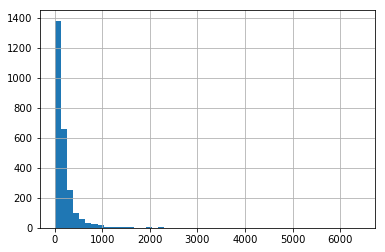

In [44]:
Comments.hist(bins=50)
plt.show()

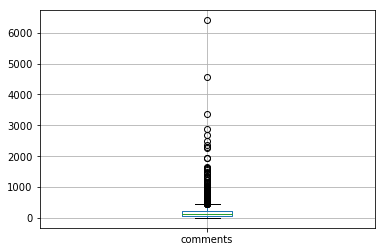

In [45]:
df.boxplot(column='comments')
plt.show()

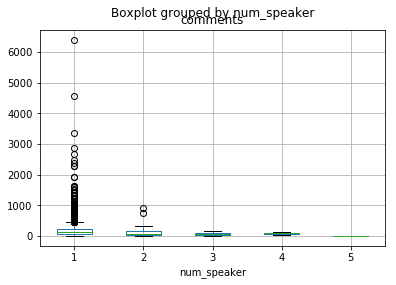

In [46]:
df.boxplot(column='comments', by = 'num_speaker')
plt.show()

In [48]:
df.groupby('event').mean()

,comments,duration,film_date,languages,num_speaker,published_date,views,M_views
event,,,,,,,,
AORN Congress,87.000000,510.000000,1.237025e+09,0.000000,1.000000,1.263028e+09,1.498180e+05,0.000000
Arbejdsglaede Live,258.000000,1092.000000,1.241482e+09,22.000000,1.000000,1.267802e+09,9.715940e+05,0.000000
BBC TV,146.000000,3955.000000,4.265316e+08,0.000000,1.000000,1.267632e+09,5.219740e+05,0.000000
Bowery Poetry Club,177.000000,182.000000,1.131805e+09,0.000000,1.000000,1.264253e+09,6.767410e+05,0.000000
Business Innovation Factory,88.000000,1105.666667,1.255018e+09,16.333333,1.000000,1.277548e+09,3.040860e+05,0.000000
Carnegie Mellon University,124.000000,4587.000000,1.190074e+09,0.000000,1.000000,1.262950e+09,5.647810e+05,0.000000
Chautauqua Institution,58.333333,1073.000000,1.254355e+09,28.333333,1.000000,1.225428e+09,2.608687e+05,0.000000
DICE Summit 2010,368.000000,1698.000000,1.266451e+09,0.000000,1.000000,1.270284e+09,4.491610e+05,0.000000
DLD 2007,67.000000,1917.000000,1.167610e+09,23.000000,1.000000,1.206323e+09,7.638150e+05,0.000000


In [49]:
df.groupby('speaker_occupation').mean()

,comments,duration,film_date,languages,num_speaker,published_date,views,M_views
speaker_occupation,,,,,,,,
Chairman of the Cordoba Initiative,152.0,1007.000000,1.255478e+09,47.000000,1.000000,1.225429e+09,4.332020e+05,0.0
"Child protection leader, activist, author",18.0,791.000000,1.464048e+09,5.000000,1.000000,1.504037e+09,6.561130e+05,0.0
Robotics engineer,10.0,651.000000,1.492992e+09,1.000000,1.000000,1.506006e+09,3.756470e+05,0.0
Space physicist,49.0,639.000000,1.446768e+09,27.000000,1.000000,1.471360e+09,1.465749e+06,1.0
3D printer,87.0,544.000000,1.394669e+09,27.000000,1.000000,1.411054e+09,2.526255e+06,1.0
3D printing entrepreneur,230.0,889.000000,1.320883e+09,20.000000,1.000000,1.327335e+09,1.595655e+06,1.0
9/11 mothers,149.0,594.000000,1.292112e+09,32.000000,1.000000,1.304362e+09,8.209760e+05,0.0
A capella ensemble,88.0,236.000000,1.233706e+09,29.000000,1.000000,1.242349e+09,1.485196e+06,1.0
AI expert,54.5,936.000000,1.492992e+09,8.000000,1.000000,1.499482e+09,9.292275e+05,0.5


In [52]:
df.groupby(['event','num_speaker'])['comments'].mean()

event                          num_speaker
AORN Congress                  1               87.000000
Arbejdsglaede Live             1              258.000000
BBC TV                         1              146.000000
Bowery Poetry Club             1              177.000000
Business Innovation Factory    1               88.000000
Carnegie Mellon University     1              124.000000
Chautauqua Institution         1               58.333333
DICE Summit 2010               1              368.000000
DLD 2007                       1               67.000000
EG 2007                        1              171.846154
EG 2008                        1              171.000000
Elizabeth G. Anderson School   1              313.000000
Eric Whitacre's Virtual Choir  1              152.000000
Fort Worth City Council        1              225.000000
Full Spectrum Auditions        1              197.333333
Gel Conference                 1              176.000000
Global Witness HQ              1             

In [53]:
df_event = df.event.astype("category")
df_event

0              TED2006
1              TED2006
2              TED2006
3              TED2006
4              TED2006
5              TED2006
6              TED2006
7              TED2006
8              TED2006
9              TED2006
10             TED2006
11             TED2006
12             TED2006
13             TED2006
14             TED2006
15             TED2006
16             TED2004
17             TED2006
18             TED2005
19      TEDGlobal 2005
20             TED2006
21             TED2004
22             TED2006
23             TED2006
24             TED2004
25      TEDGlobal 2005
26      TEDGlobal 2005
27             TED2004
28             TED2004
29             TED2004
             ...      
2520           TED2017
2521      TEDxStanford
2522           TED2017
2523      TEDxCrenshaw
2524           TED2017
2525        TEDxSydney
2526           TED2017
2527      TEDxStanford
2528       TEDxHamburg
2529        TEDxExeter
2530           TED2017
2531         TEDxGhent
2532       

In [50]:
df.to_csv('Output.csv')